Image Style Transfer Using Convolutional Neural Networks

Reference: Udacity PyTorch Scholarship Challenge from facebook program

https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf

In [0]:
#install cuda
!wget https://developer.nvidia.com/compute/cuda/9.2/Prod2/local_installers/cuda-repo-ubuntu1710-9-2-local_9.2.148-1_amd64
!dpkg -i cuda-repo-ubuntu1710-9-2-local_9.2.148-1_amd64
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get install cuda

--2019-01-29 05:46:09--  https://developer.nvidia.com/compute/cuda/9.2/Prod2/local_installers/cuda-repo-ubuntu1710-9-2-local_9.2.148-1_amd64
Resolving developer.nvidia.com (developer.nvidia.com)... 192.229.162.216
Connecting to developer.nvidia.com (developer.nvidia.com)|192.229.162.216|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod2/local_installers/cuda-repo-ubuntu1710-9-2-local_9.2.148-1_amd64.deb?pe9qLr_0aw73Rp6wQuyjfyiK89fOPrNpkl6gFhHgnDX8cHRW0UvBx_HJi8hGDjumq6a-s62a8UHXtU8nAr8rZ4bLSzZO4cvjxdCvnpOEFfnh7-RbhgCaL6EV0mzA1AYW5bM4PwWUlYs4c2jJrKIs5vl72MtapR-FqsUXVtU72az_PQbpZ9bQ-AK-fDmdiAPCVlNMlrL05-IbvHt2o7BFeA [following]
--2019-01-29 05:46:10--  https://developer.download.nvidia.com/compute/cuda/9.2/secure/Prod2/local_installers/cuda-repo-ubuntu1710-9-2-local_9.2.148-1_amd64.deb?pe9qLr_0aw73Rp6wQuyjfyiK89fOPrNpkl6gFhHgnDX8cHRW0UvBx_HJi8hGDjumq6a-s62a8UHXtU8nAr8rZ4bLSzZO4cvjxdCvnpOEFfnh7

In [0]:
!pip3 install torch torchvision

In [0]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torchvision import transforms, models

In [0]:
#import vgg19-fetures/parameter
vgg=models.vgg19(pretrained=True).features
#freeze parameters
for param in vgg.parameters():
  param.requires_grad_(False)

In [0]:
#model with GPU
device=torch.device("cuda" if torch.cuda.is_available()else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

In [0]:
!pip install Pillow==4.1.1

In [0]:
def load_image(img_path, max_size=400, shape=None):
  image=Image.open(img_path).convert("RGB")
  if max(image.size)> max_size:
    size=max_size
  else:
    size=max(image.size)

  if shape is not None:
    size=shape
   
  in_transform=transforms.Compose([transforms.Resize(size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))])
  image=in_transform(image)[:3,:,:].unsqueeze(0)
  
  return image

In [0]:
# load in content and style image
content = load_image('/content/drive/My Drive/images/IMG_20180715_132302.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('/content/drive/My Drive/images/delaunay.jpg', shape=content.shape[-2:]).to(device)

In [0]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):  
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

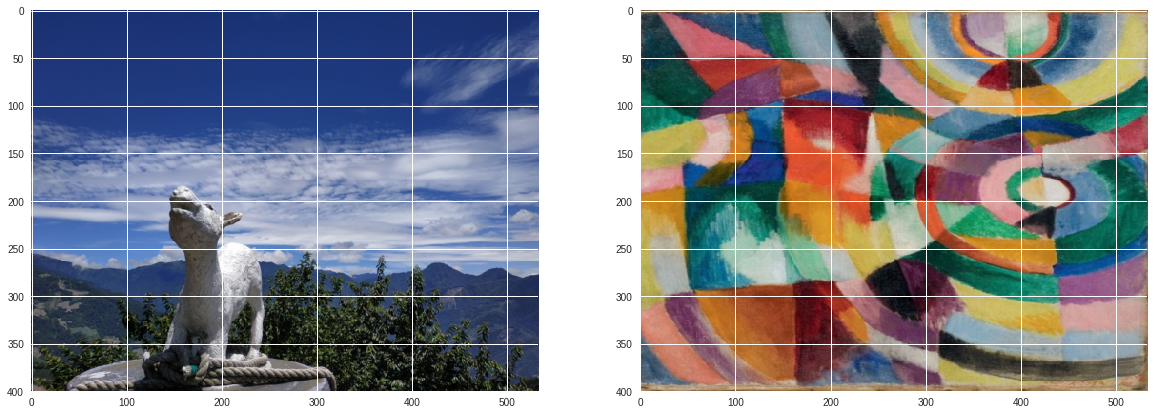

In [0]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [0]:
#define style features
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features


In [0]:
#calculate the gram matrix
def gram_matrix(tensor):
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [0]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True).to(device)

the suggested range of weight is between 0-1.Result in large style artifacts is given by the more of  earlier layers(conv1-1 and2-1)).
the rato will affect how stylized weight of final image is. the suggested content_weight is 1.

In [0]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1,
                 'conv2_1': 1,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 0.2  # alpha
style_weight = 1e6  # beta

Total loss:  11192503.0


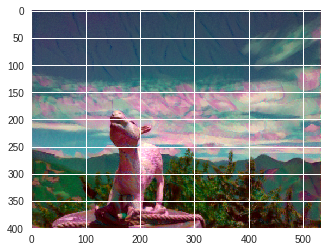

Total loss:  3724072.5


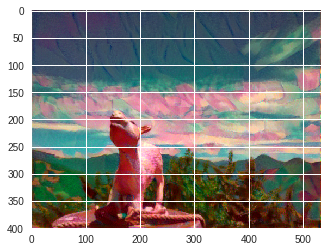

Total loss:  1899702.75


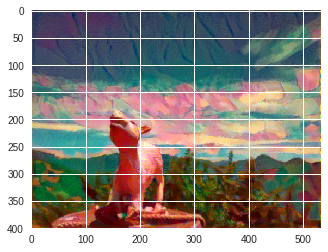

Total loss:  1091256.125


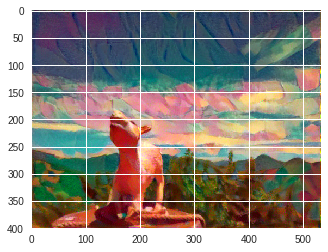

Total loss:  671390.0625


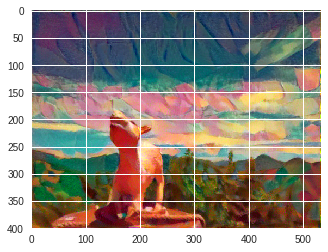

In [0]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):  
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

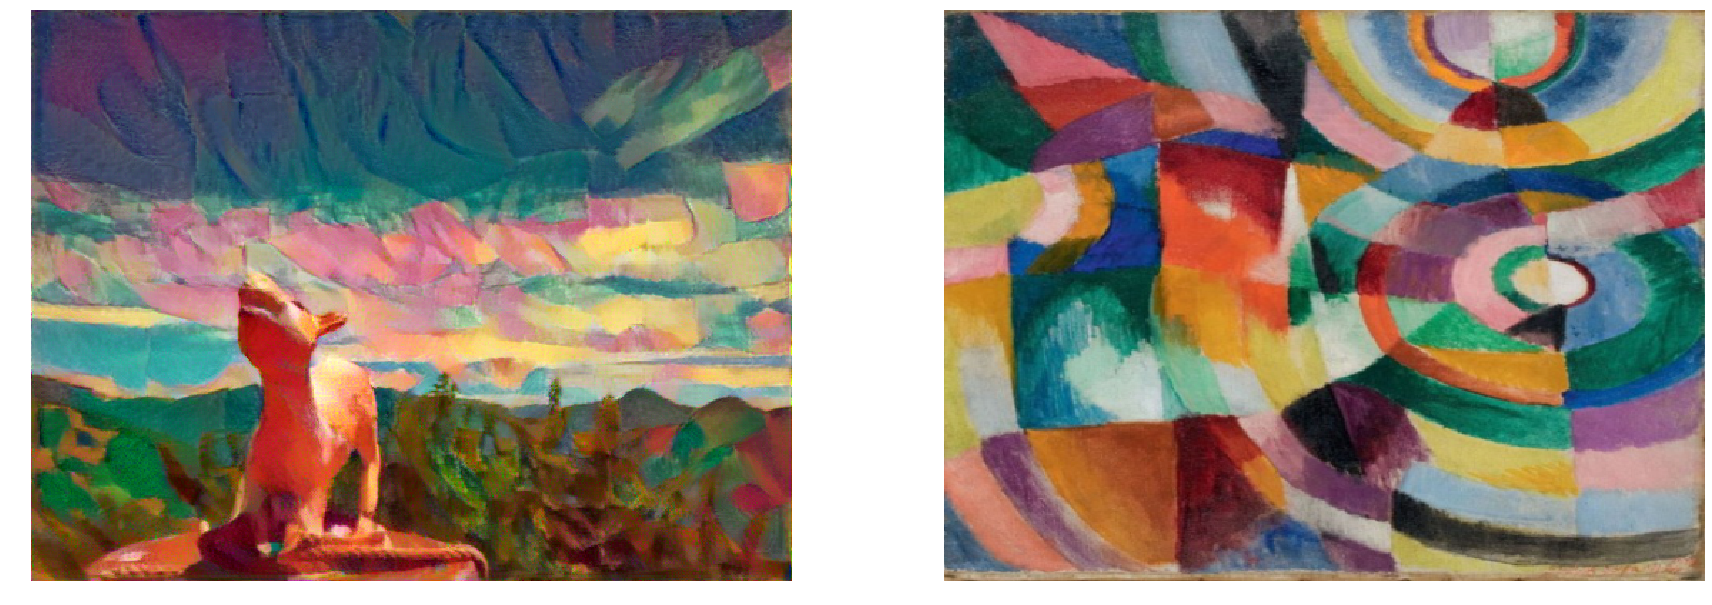

In [0]:
#display 

# display content and final, target image
fig, (ax2,ax3) = plt.subplots(1, 2, figsize=(30, 15))
for ax in (ax1, ax2, ax3):
  ax.axis('off')

ax3.imshow(im_convert(style))
ax2.imshow(im_convert(target))

